In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.autograd.profiler as profiler

In [41]:
class PositionalEncoding(nn.Module):
    '''Learnable Positional Encoding'''
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.positional_enconding = nn.Parameter(torch.randn(1, seq_len, d_model)) # Initialize positional encoding randomly as a learnable parameter

    def forward(self, x):
        return x + self.positional_enconding # Add positional encoding to the input


## ```__init__``` Method
```self.positional_encoding``` is the learnable parameter. This tensor is initialized with random values using ```torch.randn```.
Shape: ```(1, seq_len, d_model)```:

* 1: The batch dimension is set to 1 because the positional encoding is intended to be broadcasted across different batches.
* seq_len: The length of the sequence. Each position in the sequence will have a unique encoding.
* d_model: The dimensionality of the mode.

## ```forward``` Method
**Addition of Positional Encoding:**
The operation ```x + self.positional_enconding``` adds the positional encoding to the input tensor x.

**Broadcasting**: This means that the same positional encoding will be added to each sequence in the batch.

**Purpose**: The PositionalEncoding class is designed to add positional information to the input. 


In [42]:
class SelfAttentionModel(nn.Module):
    '''Self Attention Model'''
    def __init__(self, seq_len, d_model, n_heads):
        super().__init__()
        self.positional_encoding = PositionalEncoding(seq_len, d_model) # Initialize positional encoder from learnable class
        self.attention = nn.MultiheadAttention(embed_dim = d_model, num_heads = n_heads) # Define multi-head self-attention layer
        self.fc = nn.Linear(d_model,1) # Define linear layer for single output

    def forward(self, x):
        x = self.positional_encoding(x)  # Applies positional encoding
        x = x.transpose(0,1) # Transpose to match corresponding shape
        attn_output, _ = self.attention(x,x,x) # Apply self attention. x: means query, key, value (usually the same in self-attention)
        attn_output = attn_output.mean(dim = 0) # Output reduction to a single value
        output = self.fc(attn_output) #Final output
        return output

## ```SelfAttentionModel```
**Self-Attention Layer**:
Initializes a multi-head self-attention layer. This layer computes the attention scores between different positions in the sequence and combines information from multiple attention heads.

**Linear Layer**:
Defines a fully connected layer that maps the output of the self-attention layer to a single output value.

## ```forward``` Method

**Applying Positional Encoding**:
Adds positional encoding to the input tensor x. 

**Applying Self-Attention:**
Applies the self-attention layer to the input tensor x.

```attn_output``` is the output of the self-attention layer, containing attended information from all positions in the sequence.

**Pooling and Linear Transformation**:
```attn_output = attn_output.mean(dim=0)``` takes the mean of the self-attention output across the sequence length dimension (dim=0). This reduces the output to a single representation per batch. The pooled output goes through a fully connected layer ```self.fc``` to produce the final output. This maps the representation to a single value per sequence.

## Summary
The ```SelfAttentionModel``` combines positional encoding and self-attention to process sequence data. It adds positional information to the input, applies multi-head self-attention to capture dependencies between different positions in the sequence, and then uses a linear layer to produce a single output value per sequence.

In [43]:
def create_dummy_data(batch_size, seq_len, d_model):
    '''Dummy Data Generator'''
    n = 0.01 # Scaling factor for easier training
    X = torch.randn(batch_size, seq_len, d_model) * n # Tensor with shape (batch_size, seq_len, d_model)
    y = torch.randn(batch_size, 1)* n
    return X, y

## Dummy Data Generator

* Creates a dummy dataset with ```torch.randn```.
* ```n``` is a factor to scale down the generated data for easier training,

In [44]:
seq_len = 10 # Sequence Length
d_model = 16 # Model dimension
batch_size = 32 # Batch size
n_heads = 4 # Number of heads for the multi-headed method

In [47]:
# --- Model, loss function and optimizer initialization  ---
model = SelfAttentionModel(seq_len=seq_len, d_model=d_model, n_heads=n_heads)
loss_index = nn.MSELoss() # Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr = 0.0001) # Adjust learning rate as needed

loss_item = []
val_loss_item = []
num_epochs = 200 # Total epochs

# Training loop
for epoch in range(num_epochs):
    # --- Generate and Split Data ---
    X, y = create_dummy_data(batch_size, seq_len, d_model) # Dummy data
    split_index = int(0.8 * batch_size) # Split data into validation and training data
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    # --- Training Step ---    
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear gradients
    output = model(X_train)  # Forward pass on training data
    loss = loss_index(output, y_train)  # Calculate loss
    loss.backward()  # Backpropagate
    optimizer.step() # Update parameters

    # --- Validation Step ---
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradient calculation during validation
        val_output = model(X_val)  # Forward pass on validation data
        val_loss = loss_index(val_output, y_val)  # Calculate validation loss

    # Track losses
    loss_item.append(loss.item())
    val_loss_item.append(val_loss.item())

    # Print training and validation loss every 20 epochs
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.5f}, Validation Loss: {val_loss.item():.5f}')

Epoch 20, Loss: 0.01704, Validation Loss: 0.01639
Epoch 40, Loss: 0.01106, Validation Loss: 0.01299
Epoch 60, Loss: 0.00703, Validation Loss: 0.00671
Epoch 80, Loss: 0.00333, Validation Loss: 0.00404
Epoch 100, Loss: 0.00176, Validation Loss: 0.00194
Epoch 120, Loss: 0.00084, Validation Loss: 0.00051
Epoch 140, Loss: 0.00021, Validation Loss: 0.00034
Epoch 160, Loss: 0.00016, Validation Loss: 0.00006
Epoch 180, Loss: 0.00011, Validation Loss: 0.00004
Epoch 200, Loss: 0.00012, Validation Loss: 0.00016


## Training Model

* ```model``` creates an instance of the SelfAttentionModel with the specified parameters.
* ```loss_index = nn.MSELoss()``` initializes the Mean Squared Error (MSE) loss function, which is used to compute the difference between the model's predictions and the true values.
* ```optimizer = optim.Adam(model.parameters(), lr=0.0001)``` sets up the Adam optimizer with a learning rate of 0.0001. This optimizer adjusts the model’s weights to minimize the loss.
* ```X, y = create_dummy_data(batch_size, seq_len, d_model)``` generates a batch of dummy data that then its split into 80% training and 20% validation.

* ```optimizer.zero_grad()``` clears the gradients from the previous step to prevent accumulation.

* ```output = model(X)``` passes the input data X through the model to get the predicted output.

* ```loss = loss_index(output, y)``` computes the loss between the predicted output and the true values y.

* ```loss.backward()``` computes the gradient of the loss with respect to the model parameters.

* ```optimizer.step()``` updates the model parameters based on the computed gradients.

## Model Evaluation

* ```val_output = model(X_val)``` passes the validation data through the model to get the predicted output.

* ```val_loss = loss_index(val_output, y_val)``` computes the validation loss.

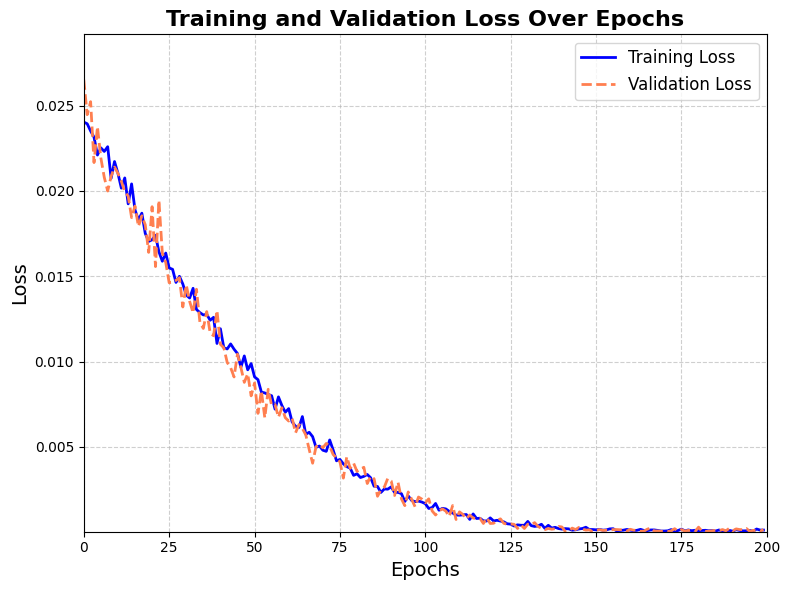

In [48]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))  # Set figure size for better resolution

# Plot the loss curves
plt.plot(loss_item, label="Training Loss", color='blue', linewidth=2)
plt.plot(val_loss_item, label="Validation Loss", color='coral', linewidth=2, linestyle='--')

# Add titles and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend
plt.legend(loc='upper right', fontsize=12)

# Tweak axis limits for better visualization
plt.xlim([0, len(loss_item)])  # Set x-axis limit from 0 to the number of epochs
plt.ylim([min(min(loss_item), min(val_loss_item)) * 0.9, max(max(loss_item), max(val_loss_item)) * 1.1])

# Display the plot
plt.tight_layout()
plt.savefig('t_n_v_loss.png', dpi=800, bbox_inches='tight')
